In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lpmv as legendre
from scipy.special import assoc_laguerre as laguerre
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure #conda install scikit-image
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
class hydrogen: 
    #Klasse der beregner stationære tilstande for hydrogen (psi_nlm), evaluereret i et 3d grid.
    def __init__(self,n,l,m,x_range):
        self.n = n
        self.l = l 
        self.m = m
        self.a = 1 #Bohr radius 
        self.m_e = 1 #Masse af elektron
        self.h_bar = 1 #h_bar 
        self.E = -self.h_bar**2/(2*self.m_e*self.a**2*n**2)
        self.front_c = np.sqrt((2/n*self.a)**3*np.math.factorial(n-l-1)/(2*n*np.math.factorial(n+l))) #Frontfaktor (4.89)
        self.Y_const = np.sqrt((2*l+1)*np.math.factorial(l-m)/(4*np.pi*np.math.factorial(l+m)))
        self.stationary = self.stationary_voxel(x_range)
        
    def to_sphere(self,x,y,z): 
        r = np.sqrt(x**2+y**2+z**2)
        phi = np.arctan2(y,x)
        theta = np.arctan2(np.sqrt(x**2+y**2),z)
        return r,phi,theta
    
    def cal_psi(self,r,phi,theta): 
        L = laguerre(2*r/(self.n*self.a),self.n-self.l-1,2*self.l+1)
        Y =  self.Y_const*np.exp(1j*self.m*phi)*legendre(self.m,self.l,np.cos(theta))
        return np.exp(-r/(self.n*self.a))*(2*r/(self.n*self.a))**self.l*L*Y
    
    def stationary_voxel(self,x_range): 
        voxel = np.zeros((len(x_range),len(x_range),len(x_range)),dtype=complex)
        for i,x in enumerate(x_range): 
            for j,y in enumerate(x_range): 
                for k,z in enumerate(x_range): 
                    r,phi,theta = self.to_sphere(x,y,z)
                    voxel[i,j,k] = self.front_c*self.cal_psi(r,phi,theta)
        return voxel
    
    def val(self,time): 
        return self.stationary*np.exp(-1j*self.E*time) 
    
    def abs_val(self,time): 
        val = self.val(time)
        return np.abs(val)**2

In [3]:
res = 75 #Antal af punkter på hver akse i 3d grid 
x = np.linspace(-15,15,res) #En af akserne - de andre to laves i klassen

psi1 = hydrogen(3,2,0,x) #Eksempler på to stationære tilstande
psi2 = hydrogen(2,1,0,x)

def wave(t): 
    wave = 1/np.sqrt(2)*(psi1.val(t)+psi2.val(t)) #Byg selv en linearkombination her! 
    return np.abs(wave)**2

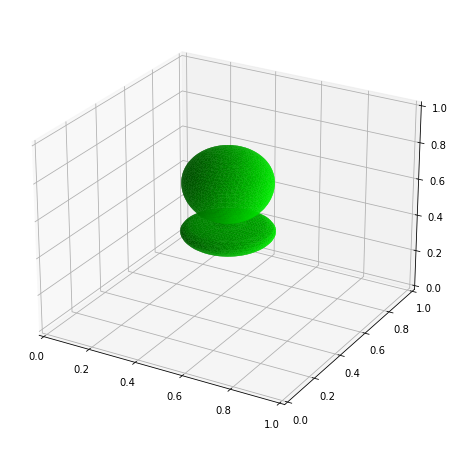

In [4]:
#Denne celle laver et plot af wave funktionen til tiden 0.
surface = 0.0002 #Værdien for overfladen der tegnes - bestemmer hvor meget der 'zoomes' ind og ud 

verts, faces, normals, values = measure.marching_cubes(wave(0), surface)
verts = verts/res
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25)

lim = 1
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.set_zlim(0,lim)
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                color='lime', lw=1)
plt.savefig('Test.png',bbox_inches='tight')
plt.show()

In [5]:
#Her animeres wave funktionen
period = 2*np.pi/abs(psi1.E - psi2.E) #Hvis der er mere end 2 funktioner skal udtrykket ændres! 
t_list = np.linspace(0,period,20)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20)
plot = ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                color='lime', lw=1)

def update(i): 
    ax.clear()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(0,1)
    voxel = wave(t_list[i])
    verts, faces, normals, values = measure.marching_cubes(voxel, surface)
    verts = verts/res
    plot = ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                color='lime', lw=1)
    return plot,

anim = FuncAnimation(fig,  # Figuren animationen skal lave på
                     update,  # funktionen der opdaterer figuren hver frame
                     frames=len(t_list),  # antal frames
                     interval=50,  # antal ms mellem hver frame
                     blit=True)#.to_jshtml()
anim.save('Test.gif')
#HTML(anim)

MovieWriter ffmpeg unavailable; using Pillow instead.
